# Single qubit GST on the 5 qubit chip (Data from 3.5.2023)

In [1]:
# Note: I removed the mGST folders from within the qibocal fork, such that it is installed and updated seperately
from mGST import compatibility,algorithm, optimization, low_level_jit, additional_fns

In [2]:
import pickle as pickle
from pygsti.report import reportables as rptbl #Needs cvxpy!
from pygsti.modelpacks import smq1Q_XYI as std
import pygsti
from argparse import Namespace
import numpy as np
import pandas as pd
import numpy.linalg as la
import json
import matplotlib.pyplot as plt

%run ./uncertainty.py
%run ../src/mGST/reporting.py

### Setting the parameters

In [7]:
pdim = 2   # physical dimension
r = pdim**2   # rank of the gate superoperators 

l = 7  # maximum number of gates in each measurement sequence
d = 3  # number of gates
n_povm = 2   # number of POVM-elements

meas_samples = 1e4

### Loading data

In [4]:
with open('data/qw5q-qubit1-fast.json') as f:
    data = json.load(f)
print(data.keys())
J = np.array(data['sequences'])[:,::-1]
y = np.array(data['hardware_probabilities']).T

dict_keys(['nsequences', 'sequence_creation_time', 'execution_time', 'sequences', 'hardware_probabilities', 'platform', 'qubit', 'depth', 'nshots'])


In [5]:
from argparse import Namespace
def bootstrap_errors(K, X, E, rho, mGST_args, bootstrap_samples, weights, gate_labels, target_mdl, parametric = True):
    ns = Namespace(**mGST_args)
    if parametric:
        y = np.real(np.array([[E[i].conj()@low_level_jit.contract(X,j)@rho for j in J] for i in range(n_povm)]))
    else: 
        y = ns.y
    X_array = np.zeros((bootstrap_samples, *X.shape)).astype(complex)
    E_array = np.zeros((bootstrap_samples, *E.shape)).astype(complex)
    rho_array = np.zeros((bootstrap_samples, *rho.shape)).astype(complex)
    df_g_list = []
    df_o_list = []
    
    for i in range(bootstrap_samples):        
        y_sampled = additional_fns.sampled_measurements(y, ns.meas_samples).copy()
        K_, X_, E_, rho_, _ = algorithm.run_mGST(y_sampled[:,:100],ns.J[:100],ns.l,ns.d,ns.r,ns.rK, ns.n_povm, ns.bsize, ns.meas_samples, method = ns.method,
                     max_inits = ns.max_inits, max_iter = ns.max_iter, final_iter = ns.final_iter, threshold_multiplier = ns.threshold_multiplier, 
                     target_rel_prec = ns.target_rel_prec, init = [K, E, rho], testing = False)   
        K_, X_, E_, rho_, _ = algorithm.run_mGST(y_sampled,ns.J,ns.l,ns.d,ns.r,ns.rK, ns.n_povm, ns.bsize, ns.meas_samples, method = ns.method,
                         max_inits = ns.max_inits, max_iter = 0, final_iter = ns.final_iter, threshold_multiplier = ns.threshold_multiplier, 
                         target_rel_prec = ns.target_rel_prec, init = [K_, E_, rho_], testing = False)   

        X_opt, E_opt, rho_opt = gauge_opt(X_, E_, rho_, target_mdl, weights)
        df_g, df_o, _, _ = report(X_opt, E_opt, rho_opt, J, y_sampled, target_mdl, gate_labels)
        df_g_list.append(df_g.values)
        df_o_list.append(df_o.values)

        X_opt_pp, E_opt_pp, rho_opt_pp = compatibility.std2pp(X_opt, E_opt, rho_opt)
        
        X_array[i, :] = X_opt_pp
        E_array[i, :] = E_opt_pp
        rho_array[i, :] = rho_opt_pp
        
    return (X_array, E_array, rho_array, np.array(df_g_list), np.array(df_o_list))

### GST

Starting optimization...
 44%|██████████████████▊                        | 35/80 [00:25<00:32,  1.40it/s]


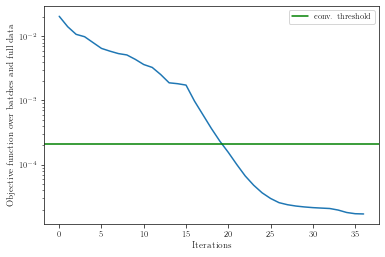

#################
	 Convergence criterion satisfied
	 Final objective function value 1.7057202711251074e-05 with # of initializations: 1 
 	 Total runtime: 25.419617414474487


In [6]:
bsize = 50   # The batch size on which the optimization is started


rK = 4
mGST_args = {'y': y, 'J': J, 'l': l, 'd': d, 'r': r, 'rK': rK, 'n_povm': n_povm, 'bsize': bsize, 
             'meas_samples': meas_samples, 'method': 'SFN', 'max_inits': 20, 'max_iter': 0, 
             'final_iter': 80, 'threshold_multiplier': 10, 'target_rel_prec': 1e-3}
ns = Namespace(**mGST_args)

results = []
X_t,E_t,rho_t = compatibility.pygsti_model_to_arrays(std.target_model(),basis = 'std') #The idle-X(pi/2)-Y(pi/2) model 
K_t = additional_fns.Kraus_rep(X_t,d,pdim,rK)
X_t = np.einsum('ijkl,ijnm -> iknlm', K_t, K_t.conj()).reshape(d,r,r)  
K,X,E,rho,res_list = algorithm.run_mGST(ns.y,ns.J,ns.l,ns.d,ns.r,ns.rK, ns.n_povm, ns.bsize, ns.meas_samples, method = ns.method,
                 max_inits = ns.max_inits, max_iter = ns.max_iter, final_iter = ns.final_iter, threshold_multiplier = ns.threshold_multiplier, 
                 target_rel_prec = ns.target_rel_prec, init = [K_t, E_t, rho_t], testing = True)   
results.append([K,X,E,rho])

In [8]:
weights = {'G0': 1,'G1': 1, 'G2': 1, 'spam': 1}
gate_labels = {0: "Id", 1: "Rx(pi/2)", 2: "Ry(pi/2)"}
X_opt, E_opt, rho_opt = gauge_opt(X, E, rho, std.target_model(), weights)
df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J, y, std.target_model(), gate_labels)
display(s_g), display(s_o)  

mGST_args = {'y': y, 'J': J, 'l': l, 'd': d, 'r': r, 'rK': rK, 'n_povm': n_povm, 'bsize': bsize, 
             'meas_samples': meas_samples, 'method': 'SFN', 'max_inits': 20, 'max_iter': 0, 
             'final_iter': 80, 'threshold_multiplier': 10, 'target_rel_prec': 1e-3}

X_array, E_array, rho_array, df_g_array, df_o_array = bootstrap_errors(K_t,X_t,E_t,rho, mGST_args, 10, weights, gate_labels, std.target_model(), parametric = False)

,F_avg,Diamond distances,Min. Spectral distances
Id,"0,98413","0,08090","0,08166"
Rx(pi/2),"0,98293","0,05235","0,02652"
Ry(pi/2),"0,98476","0,04797","0,02366"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.000017,0.003248,0.121432,0.087260,0.040945


Starting optimization...
 44%|██████████████████▊                        | 35/80 [00:24<00:31,  1.44it/s]
#################
	 Convergence criterion satisfied
	 Final objective function value 3.187360073389962e-05 with # of initializations: 1 
 	 Total runtime: 24.39378571510315
Starting optimization...
  2%|█                                           | 2/80 [00:02<01:20,  1.03s/it]
#################
	 Convergence criterion satisfied
	 Final objective function value 3.1251995647942025e-05 with # of initializations: 1 
 	 Total runtime: 2.0624501705169678
Starting optimization...
 42%|██████████████████▎                        | 34/80 [00:24<00:32,  1.41it/s]
#################
	 Convergence criterion satisfied
	 Final objective function value 4.5623799167036035e-05 with # of initializations: 1 
 	 Total runtime: 24.105666875839233
Starting optimization...
  0%|                                                    | 0/80 [00:00<?, ?it/s]
#################
	 Convergence criterion satisfied
	

### Save data

In [9]:
# ###################################### 
# filename = 'results-qubit1-fast_bootstrap'
# results = {'estimates': (K,X,E,rho), 'gauge_opt_estimates': (X_opt, E_opt, rho_opt),  'bootstrap_data': (X_array, E_array, rho_array, df_g_array, df_o_array)}
# data_to_safe = {'parameters': mGST_args, 'results': results}

# with open(filename, 'wb') as handle:
#     pickle.dump(data_to_safe, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Analysis

### Rank 4 with boostrapped errors

In [10]:
for i in range(1,2):
    filename = "results-qubit%i-fast_bootstrap"%i
    with open(filename, 'rb') as handle:
        b = pickle.load(handle)
    mGST_args = b['parameters']
    X_array, E_array, rho_array, df_g_array, df_o_array = b['results']['bootstrap_data']
    K,X,E,rho = b['results']['estimates']
    X_opt, E_opt, rho_opt = b['results']['gauge_opt_estimates']
    J = b['parameters']['J']
    y = b['parameters']['y']

    gate_labels = {0: "Id", 1: "Rx(pi/2)", 2: "Ry(pi/2)"}
    df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J, y, std.target_model(), gate_labels)
    
    percentiles_g = np.percentile(np.abs(df_g_array - np.array([df_g.values for _ in range(10)])), [0.9] , axis = 0)
    percentiles_o = np.percentile(np.abs(df_o_array - np.array([df_o.values for _ in range(10)])), [0.9] , axis = 0).reshape(-1)

    display(s_g), display(s_o)   

,F_avg,Diamond distances,Min. Spectral distances
Id,"0,98413","0,08090","0,08166"
Rx(pi/2),"0,98293","0,05235","0,02652"
Ry(pi/2),"0,98476","0,04797","0,02366"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.000017,0.003248,0.121432,0.087260,0.040945


In [11]:
df_g_err = pd.DataFrame({
    "F_avg": [number_to_str(df_g.values[i,0], percentiles_g[0,i,0]) for i in range(len(gate_labels))],
    "Diamond distances": [number_to_str(df_g.values[i,1], percentiles_g[0,i,1]) for i in range(len(gate_labels))],
    "Min. Spectral distances": [number_to_str(df_g.values[i,2], percentiles_g[0,i,2]) for i in range(len(gate_labels))]
})
df_o_err = pd.DataFrame({
    "Final cost function value": number_to_str(df_o.values[0,0], percentiles_o[0]),
    "Mean total variation dist. to data": number_to_str(df_o.values[0,1], percentiles_o[1]),
    "Mean total variation dist. target to data": number_to_str(df_o.values[0,2], percentiles_o[2]),
    "POVM - Choi map trace distance": number_to_str(df_o.values[0,3], percentiles_o[3]),
    "State - Trace distance": number_to_str(df_o.values[0,4], percentiles_o[4]),  
}, index = [0])
df_g_err.rename(index=gate_labels, inplace = True)
df_o_err.rename(index={0: ""}, inplace = True)

In [12]:
display(df_g_err)
display(df_o_err)

,F_avg,Diamond distances,Min. Spectral distances
Id,0.9841 ± 0.0004,0.08090 ± 0.00005,0.0817 ± 0.0004
Rx(pi/2),0.9829 ± 0.0001,0.0523 ± 0.0003,0.02652 ± 0.00004
Ry(pi/2),0.9848 ± 0.0002,0.0480 ± 0.0004,0.0237 ± 0.0002


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.000017 ± 0.000006,0.0032 ± 0.0005,0.12143 ± 0.00007,0.08726 ± 0.00007,0.04095 ± 0.00005


### Rank 4

In [37]:
for i in range(1,4):
    filename = "results-qubit%i-fast"%i
    with open(filename, 'rb') as handle:
        b = pickle.load(handle)
    results = b['results']

    # Performance metrics rank 4
    print("\n", filename)
    K,X,E,rho = results[1][:]
    J = b['parameters']['J']
    y = b['parameters']['y']
    
    weights = {'G0': 1,'G1': 1, 'G2': 1, 'spam': 1}
    gate_labels = {0: "Id", 1: "Rx(pi/2)", 2: "Ry(pi/2)"}
    X_opt, E_opt, rho_opt = gauge_opt(X, E, rho, std.target_model(), weights)
    df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J, y, std.target_model(), gate_labels)
    display(s_g), display(s_o)   


 results-qubit1-fast


,F_avg,Diamond distances
Id,"0,98384","0,08122"
Rx(pi/2),"0,98337","0,05048"
Ry(pi/2),"0,98468","0,04709"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.000017,0.003181,0.121432,0.088033,0.040173



 results-qubit2-fast


,F_avg,Diamond distances
Id,"0,98562","0,11697"
Rx(pi/2),"0,99092","0,04480"
Ry(pi/2),"0,99228","0,04175"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.000018,0.003462,0.122045,0.077274,0.074279



 results-qubit3-fast


,F_avg,Diamond distances
Id,"0,99145","0,03491"
Rx(pi/2),"0,99247","0,02693"
Ry(pi/2),"0,99233","0,02613"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.000017,0.003252,0.053052,0.036470,0.018129


### Gate plots


 results-qubit1-fast


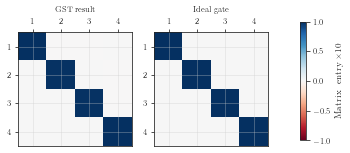

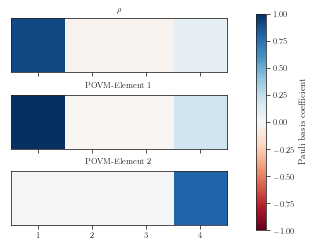

In [41]:
filename = "results-qubit1-fast"
with open(filename, 'rb') as handle:
    b = pickle.load(handle)
results = b['results']

# Performance metrics rank 1
print("\n", filename)
K,X,E,rho = results[0][:]
J = b['parameters']['J']
y = b['parameters']['y']

weights = {'G0': 1,'G1': 1, 'G2': 1, 'spam': 1}
gate_labels = {0: "Id", 1: "Rx(pi/2)", 2: "Ry(pi/2)"}
X_opt, E_opt, rho_opt = gauge_opt(X, E, rho, std.target_model(), weights)

plot_mat(X_opt[0], X_t[0])
plot_spam(rho_opt, E_opt)